# 1. Setup

## 1.1 Install Dependencies

In [1]:
#docker pull tensorflow/tensorflow:2.13-jupyter
#docker pull tensorflow/tensorflow:2.17.0rc0-jupyter
#docker run -it --rm -v $(realpath ~/notebooks):/tf/notebooks -p 8888:8888 tensorflow/tensorflow:2.17.0rc0-jupyter
#docker run -it --rm -v $(realpath ~/notebooks):/tf/notebooks -p 8888:8888 tensorflow/tensorflow:latest-jupyter

In [47]:
WEBCAM=1

In [49]:
!pip install tensorflow opencv-python matplotlib

Defaulting to user installation because normal site-packages is not writeable


## 1.2 Import Dependencies

In [52]:
# Import standard dependencies
import cv2
import os
import requests
import tarfile
import random
import uuid
import numpy as np
from matplotlib import pyplot as plt

# Import tensorflow dependencies - Functional API
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Layer, Conv2D, Dense, MaxPooling2D, Input, Flatten
import tensorflow as tf

## 1.3 Set GPU Growth

In [55]:
print(f"{len(tf.config.list_physical_devices('GPU'))}, gpus are coming to the party")
if len(tf.config.list_physical_devices('GPU')) > 0:
    print("GPU is available")
    # Avoid OOM errors by setting GPU Memory Consumption Growth
    gpus = tf.config.experimental.list_physical_devices('GPU')
    for gpu in gpus: 
        tf.config.experimental.set_memory_growth(gpu, True)
else:
    print("GPU is not available")

0, gpus are coming to the party
GPU is not available


## 1.4 Create Folder Structures

In [58]:
# Setup paths
POS_PATH = os.path.join('data', 'positive')
NEG_PATH = os.path.join('data', 'negative')
ANC_PATH = os.path.join('data', 'anchor')
APP_PATH = os.path.join('application_data', 'verification_images')
APPV_PATH = os.path.join('application_data', 'input_image')

In [60]:
# Make the directories
if not os.path.exists(POS_PATH):
    os.makedirs(POS_PATH)
if not os.path.exists(NEG_PATH):
    os.makedirs(NEG_PATH)
if not os.path.exists(ANC_PATH):
    os.makedirs(ANC_PATH)
if not os.path.exists(APP_PATH):
    os.makedirs(APP_PATH)
if not os.path.exists(APPV_PATH):
    os.makedirs(APPV_PATH)

## 2.1 Untar Labelled Faces in the Wild Dataset

In [63]:
# check if Labeled Faces in the Wild tgz exists
PATH = './lfw.tgz'
if os.path.isfile(PATH) and os.access(PATH, os.R_OK):
    print( "ok: lfw.tgz exists")
else:
    print( "problem: lfw.tgz does NOT exist")
    print("          download lfw.tgz from here:")
    print("          https://vis-www.cs.umass.edu/lfw/#download")
    print("          and place it in the project root dir")

ok: lfw.tgz exists


In [65]:
MINIMUM_SIZE = 200

file_count = 0
for entry in os.scandir(NEG_PATH):
    if entry.is_file():
        file_count += 1
    if file_count == MINIMUM_SIZE:
        break
        # Uncompress Tar GZ Labelled Faces in the Wild Dataset

enough_files = (file_count == MINIMUM_SIZE)

if ( file_count < MINIMUM_SIZE ):
    print( "info: lfw.tgz was not extracted before: "+ str(file_count) + " in "+ NEG_PATH)
    if os.path.isfile(PATH) and os.access(PATH, os.R_OK):
        print("info: lfw.tgz exists and is readable")
        print( "info: extracting lfw.tgz")
        !tar -xf lfw.tgz
        # Move LFW Images to the following repository data/negative
        print( "info: moving extracted lfw.tgz files to NEG_PATH")
        for directory in os.listdir('lfw'):
            for file in os.listdir(os.path.join('lfw', directory)):
                EX_PATH = os.path.join('lfw', directory, file)
                NEW_PATH = os.path.join(NEG_PATH, file)
                os.replace(EX_PATH, NEW_PATH)   
    else:
        print( "problem: lfw.tgz does NOT exist.")
        print( "          can NOT extract.")

elif ( file_count == MINIMUM_SIZE):
    print( "ok: lfw.tgz was previously extracted: " + str(len([name for name in os.listdir(NEG_PATH) if os.path.isfile(os.path.join(NEG_PATH, name))])) + " images are present in NEG_PATH" )


ok: lfw.tgz was previously extracted: 13237 images are present in NEG_PATH


## 2.2 mobilenet model

In [68]:
# Global variable to store the loaded model for face recog
loaded_model = None

In [70]:
# download and extract
def download_and_extract_model(url, dest_dir):
    # Download the file
    filename = url.split("/")[-1]
    file_path = os.path.join(dest_dir, filename)
    
    print(f"info: Downloading {filename}...")
    response = requests.get(url, stream=True)
    with open(file_path, 'wb') as f:
        for chunk in response.iter_content(chunk_size=1024):
            if chunk:
                f.write(chunk)
    print(f"info: Downloaded {filename} to {file_path}")
    
    # Extract the tar.gz file
    print(f"info: Extracting {filename}...")
    with tarfile.open(file_path, "r:gz") as tar:
        tar.extractall(path=dest_dir)
    print(f"info: Extracted to {dest_dir}")

    # Clean up: remove the tar.gz file
    os.remove(file_path)
    print(f"info: Removed {filename}")

In [72]:
def load_model(model_path):
    global loaded_model
    if loaded_model is None:
        print("info: Loading model...")
        loaded_model = tf.saved_model.load(model_path)
        print("info: done.")
    else:
        print("ok: Model already loaded.")
    return loaded_model

In [74]:
# URL of the model
model_url = "http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8.tar.gz"
# Destination directory to save the model
destination_dir = "models"
model_path = 'models/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model'  # Path to your .pb model directory

# Create the destination directory if it does not exist
if not os.path.exists(destination_dir):
    os.makedirs(destination_dir)

# Download and extract the model
# check if Labeled Faces in the Wild tgz exists
PATH_TO_MODEL = model_path + '/saved_model.pb'
if os.path.isfile(PATH_TO_MODEL) and os.access(PATH_TO_MODEL, os.R_OK):
    print( "ok: saved_model.pb exists at: " + PATH_TO_MODEL)
else:
    print( "info: saved_model.pb does NOT exist: " + PATH_TO_MODEL)
    print( "info: downloading from: " + model_url)
    print( "info: and extracting to: " + model_path )
    download_and_extract_model(model_url, destination_dir)
    loaded_model = None

ok: saved_model.pb exists at: models/ssd_mobilenet_v2_fpnlite_320x320_coco17_tpu-8/saved_model/saved_model.pb


In [76]:
# Load the pre-trained TensorFlow model
model = load_model(model_path)

info: Loading model...
info: done.


In [78]:
# Function to perform face detection
def detect_faces(image):
    input_tensor = tf.convert_to_tensor([image], dtype=tf.uint8)
    detections = model(input_tensor)
    return detections

## 2.3 Collect Positives and Anchors

In [81]:
os.path.join(ANC_PATH, '{}.jpg'.format(uuid.uuid4().int))

'data\\anchor\\190902447036408496397824587835452345319.jpg'

In [134]:
# Initialize the webcam with face detection
cap = cv2.VideoCapture(WEBCAM)
collect_anchor = True
collect_positive = False
anchor_input = 0
positive_input = 0
how_many_to_gather = 30
got_enough = False

try:
    while cap.isOpened():
        ret, frame = cap.read()

        if not ret:
            print("problem: failed to grab frame")
            break
        
        # Cut down frame to 250x250px
        frame = frame[120:120+250, 200:200+250, :]
        
        # Create a copy of the frame before any modifications
        original_frame = frame.copy()

        # Convert the image to RGB (optional, depending on your face detection function)
        rgb_frame = frame

        # Perform face detection
        detections = detect_faces(rgb_frame)

        # Extract detection results
        detection_boxes = detections['detection_boxes'][0]
        detection_scores = detections['detection_scores'][0]

        # Loop through detections and draw boxes around faces
        height, width, _ = frame.shape
        for i in range(detection_boxes.shape[0]):
            if detection_scores[i] >= 0.5:  # Confidence threshold
                box = detection_boxes[i]
                y1, x1, y2, x2 = int(box[0] * height), int(box[1] * width), int(box[2] * height), int(box[3] * width)
                
                # Draw the bounding box
                cv2.rectangle(rgb_frame, (x1, y1), (x2, y2), (0, 255, 255), 2)  # Yellow box (BGR: 0, 255, 255)
                
                # Prepare the label with the detection score
                label = f'{detection_scores[i]:.2f}'
                label_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
                label_x1, label_y1 = x1, y1
                label_x2, label_y2 = x1 + label_size[0] + 10, y1 + label_size[1] + 10
                cv2.rectangle(rgb_frame, (label_x1, label_y1), (label_x2, label_y2), (0, 255, 255), cv2.FILLED)
                cv2.putText(rgb_frame, label, (x1 + 5, y1 + label_size[1] + 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

                # Collect anchors
                if detection_scores[i] >= 0.81 and collect_anchor:
                    if anchor_input < how_many_to_gather:
                        imgname = os.path.join(ANC_PATH, f'{uuid.uuid4().int}.jpg')
                        cv2.imwrite(imgname, original_frame)  # Save the original frame
                        anchor_input += 1
                        collect_anchor = False
                        collect_positive = True

                # Collect positives
                if detection_scores[i] >= 0.81 and collect_positive:
                    if positive_input < how_many_to_gather:
                        imgname = os.path.join(POS_PATH, f'{uuid.uuid4().int}.jpg')
                        cv2.imwrite(imgname, original_frame)  # Save the original frame
                        positive_input += 1
                        collect_anchor = True
                        collect_positive = False

                # Quit when 30 positives and 30 anchors have been collected
                if positive_input >= how_many_to_gather and anchor_input >= how_many_to_gather:
                    print(f'Quitting collection because {how_many_to_gather} images were collected.')
                    got_enough = True
                    break

        # Display the resulting frame
        cv2.imshow('Anchor & Positives', rgb_frame)
        
        # Breaking gracefully
        if (cv2.waitKey(1) & 0xFF == ord('q')) or got_enough:
            break
except Exception as e:
    print(f"An error occurred: {e}")
finally:
    # Release the webcam
    cap.release()
    # Close the image show frame
    cv2.destroyAllWindows()


imgname: data\positive\329352989251219261123334397116707813901.jpg


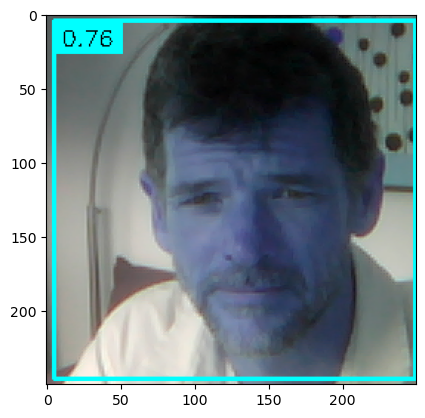

In [143]:
import glob
from pathlib import Path
try:
    frame
except NameError:
    print("frame is NOT defined yet!")
else:
    plt.imshow(frame)

# Undefine the variable
#del imgname

try:
    imgname
except NameError:
    print("imgname is NOT defined yet!")
    folder_path = Path(os.path.join(ANC_PATH))
    print("looking in: " + str(folder_path))
    list_of_paths = list(folder_path.glob('*.jpg'))
    if list_of_paths:
        latest_file = max(list_of_paths, key=lambda p: p.stat().st_ctime)
        print("latest file: " + str(latest_file))
        imgname = os.path.join(latest_file)
        print("imgname set to: " + str(imgname))
    else:
        print("No .jpg files found in " + ANC_PATH)
else:
    print("imgname: " + str(imgname))


# 2.x Data Augmentation

In [145]:
def data_aug(img):
    dataset = []
    for i in range(9):
        #img = tf.image.stateless_random_brightness(img, max_delta=0.02, seed=(1,2))
        #img = tf.image.stateless_random_contrast(img, lower=0.6, upper=1, seed=(1,3))
        # img = tf.image.stateless_random_crop(img, size=(20,20,3), seed=(1,2))
        img = tf.image.stateless_random_flip_left_right(img, seed=(np.random.randint(100),np.random.randint(100)))
        #img = tf.image.stateless_random_jpeg_quality(img, min_jpeg_quality=90, max_jpeg_quality=100, seed=(np.random.randint(100),np.random.randint(100)))
        #img = tf.image.stateless_random_saturation(img, lower=0.9,upper=1, seed=(np.random.randint(100),np.random.randint(100)))
            
        dataset.append(img)
    
    return dataset

# 3. Load and Preprocess Images

In [148]:
img_path = imgname
print('image path:' +str(img_path))
img = cv2.imread(img_path)


image path:data\positive\329352989251219261123334397116707813901.jpg


In [150]:
augmented_images = data_aug(img)
for image in augmented_images:
    cv2.imwrite(os.path.join(ANC_PATH, '{}.jpg'.format(int(uuid.uuid4() ) )), image.numpy() )


## 3.1 Get Image Directories

In [202]:
anchor = tf.data.Dataset.list_files(ANC_PATH+'\*.jpg').take(100)
positive = tf.data.Dataset.list_files(POS_PATH+'\*.jpg').take(100)
negative = tf.data.Dataset.list_files(NEG_PATH+'\*.jpg').take(300)

In [204]:
dir_test_anchor = anchor.as_numpy_iterator()
dir_test_positive = positive.as_numpy_iterator()
dir_test_negative = negative.as_numpy_iterator()

In [206]:
print(dir_test_anchor.next())
print(dir_test_positive.next())
print(dir_test_negative.next())

b'data\\anchor\\200353796322721453159534290231389666850.jpg'
b'data\\positive\\334216125014583303252633535533046831652.jpg'
b'data\\negative\\Rafiq_Hariri_0001.jpg'


## 3.2 Preprocessing - Scale and Resize

In [209]:
import tensorflow as tf

def preprocess(file_path):
    # Ensure file_path is converted to string tensor
    if isinstance(file_path, bytes):
        file_path = tf.convert_to_tensor(file_path, dtype=tf.string)
    elif isinstance(file_path, tf.Tensor):
        file_path = tf.cast(file_path, tf.string)

    # Read in the image from file path
    byte_img = tf.io.read_file(file_path)
    # Decode the image
    img = tf.io.decode_jpeg(byte_img, channels=3)
    
    # Preprocessing steps - resizing the image to be 100x100x3
    img = tf.image.resize(img, (100, 100))
    # Scale image to be between 0 and 1 
    img = img / 255.0

    # Return the processed image
    return img


In [211]:
print('preprocessing file: ' + str(imgname))
img = preprocess(imgname)

preprocessing file: data\positive\329352989251219261123334397116707813901.jpg


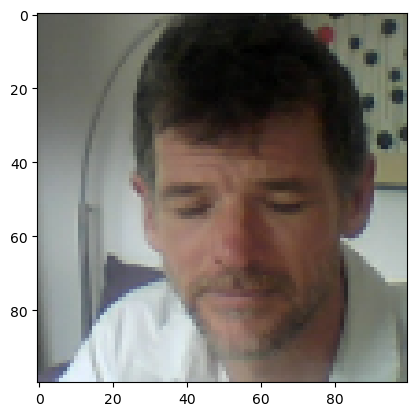

In [213]:
img.numpy().max() 
plt.imshow(img)

In [215]:
# dataset.map(preprocess)

## 3.3 Create Labelled Dataset

In [218]:
# (anchor, positive) => 1,1,1,1,1
# (anchor, negative) => 0,0,0,0,0

In [220]:
#creating labeled dataset
positives = tf.data.Dataset.zip((anchor, positive, tf.data.Dataset.from_tensor_slices(tf.ones(len(anchor)))))
negatives = tf.data.Dataset.zip((anchor, negative, tf.data.Dataset.from_tensor_slices(tf.zeros(len(anchor)))))
dataset = []
dataset = positives.concatenate(negatives)
#dataset = negatives.concatenate(positives)


In [222]:
print(' there are ' + str(tf.ones(len(anchor)).shape[0]) + ' ones in ' + ANC_PATH)
print(' there are ' + str(tf.ones(len(positive)).shape[0]) + ' ones in ' + POS_PATH)
print(' there are ' + str(tf.zeros(len(negative)).shape[0]) + ' zeros in ' + NEG_PATH)

 there are 100 ones in data\anchor
 there are 100 ones in data\positive
 there are 300 zeros in data\negative


In [224]:
samples = dataset.as_numpy_iterator()

In [226]:
example = samples.next()

In [228]:
#example

In [230]:
len(dataset)

200

## 3.4 Build Train and Test Partition

In [233]:
# this basically takes:
# (b'data\\anchor\\71636906539880418712600979738986621799.jpg',
#  b'data\\positive\\149034039615166075668887512147981363189.jpg',
#  1.0)
# and preprocesses them
def preprocess_twin(input_img, validation_img, label):
    return preprocess(input_img), preprocess(validation_img), label

In [235]:
res = preprocess_twin(*example)

print(' returns ' + str(len(res)) + ' items')
print(' a ' + str(res[0].shape) + ' shape')
print(' a ' + str(res[1].shape) + ' shape')
print('and a label of ' + str(res[2]))


 returns 3 items
 a (100, 100, 3) shape
 a (100, 100, 3) shape
and a label of 1.0


 plot the 0


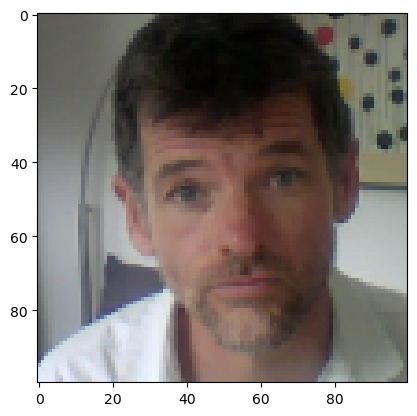

In [237]:
# which we can plot
print(' plot the 0')
plt.imshow(res[0])

 plot the 1


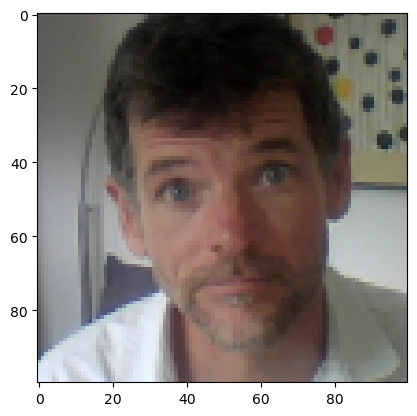

In [239]:
print(' plot the 1')
plt.imshow(res[1])

In [241]:
input_img, validation_img, label = example
#regular_string = byte_string.decode('utf-8')

print(input_img.decode('utf-8'))   # b'data\\anchor\\127470327868448223408149513670085446674.jpg'
print(validation_img.decode('utf-8')) # b'data\\positive\\1634237672113708953579402914796074059.jpg'
print(label)   # 1.0


data\anchor\265057532757953607724758962843883674148.jpg
data\positive\26221132658999336189837955993362004922.jpg
1.0


In [243]:
# Unpack the tuple
anchor_path, positive_path, label = example

# Convert the byte strings to regular strings (if needed)
anchor_path = anchor_path.decode('utf-8')
positive_path = positive_path.decode('utf-8')

# Print the results
print("Anchor Path:", anchor_path)
print("Positive Path:", positive_path)
print("Label:", label)

Anchor Path: data\anchor\265057532757953607724758962843883674148.jpg
Positive Path: data\positive\26221132658999336189837955993362004922.jpg
Label: 1.0


In [245]:
# Build dataloader pipeline
dataset = dataset.map(preprocess_twin)
# # Check the output
#for input_img, validation_img, label in data.take(1):
#    print("Input Image:", input_img)
#    print("Validation Image:", validation_img)
#    print("Label:", label)
dataset = dataset.cache()
dataset = dataset.shuffle(buffer_size=1024)
# when passing dataset to the trainer, we need a mixed set

In [247]:
samples = []

In [249]:
samples = dataset.as_numpy_iterator()

In [251]:
samp2 = samples.next()

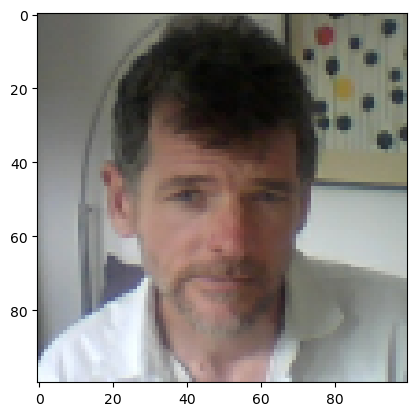

In [253]:
plt.imshow(samp2[0]) # anchor image

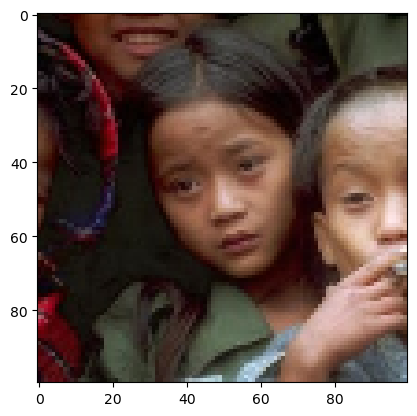

In [255]:
plt.imshow(samp2[1]) # anchor image

In [257]:
if samp2[2] < 1 :
    print ('those images do not match: ' + str(samp2[2]))
else:
    print ('those images do match: ' + str(samp2[2]))

those images do not match: 0.0


In [259]:
print('there are '+ str(len(dataset)) +' items in our dataset')
print('  50% of that is: ' + str(round(len(dataset)*.5)) )
print('  70% of that in our train_data: ' + str(round(len(dataset)*.7)) )
print('  30% of that in our test_data: ' + str(round(len(dataset)*.3)) )

there are 200 items in our dataset
  50% of that is: 100
  70% of that in our train_data: 140
  30% of that in our test_data: 60


In [261]:
dataset

<_ShuffleDataset element_spec=(TensorSpec(shape=(100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(), dtype=tf.float32, name=None))>

In [263]:
# Assuming `dataset` is your _PrefetchDataset object
element_spec = dataset.element_spec

# Extracting the shape from the first TensorSpec in element_spec
shape = element_spec[0].shape

# Converting the shape to a string

print(' dataset has ' + str(len(dataset)) + ' items')
print(' dataset has ' + str(shape) + ' shape')

 dataset has 200 items
 dataset has (100, 100, 3) shape


In [265]:
# Training partition
# this takes a certain percentage of the data
train_data = []
train_data = dataset.take(round(len(dataset)*.7))
train_data = train_data.batch(16)
train_data = train_data.prefetch(8)

In [267]:
train_data

<_PrefetchDataset element_spec=(TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None, 100, 100, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.float32, name=None))>

In [269]:
# Assuming `dataset` is your _PrefetchDataset object
element_spec = train_data.element_spec

# Extracting the shape from the first TensorSpec in element_spec
shape = element_spec[0].shape

# Converting the shape to a string

print(' train_data has ' + str(shape) + ' shape')

 train_data has (None, 100, 100, 3) shape


In [271]:
train_samples = train_data.as_numpy_iterator()
train_sample = train_samples.next()
print(' we are batching ' + str(len(train_sample[0])) +' images in each sample')

 we are batching 16 images in each sample


In [273]:
# Testing partition
test_data = []
test_data = dataset.skip(round(len(dataset)*.7))
test_data = test_data.take(round(len(dataset)*.3))
test_data = test_data.batch(16)
test_data = test_data.prefetch(8)
len(test_data)

4

# 4. Model Engineering

## 4.1 Build Embedding Layer

In [277]:
inp = Input(shape=(100,100,3), name='input_image')

In [279]:
c1 = Conv2D(64, (10,10), activation='relu')(inp)

In [281]:
m1 = MaxPooling2D(64, (2,2), padding='same')(c1)

In [283]:
c2 = Conv2D(128, (7,7), activation='relu')(m1)
m2 = MaxPooling2D(64, (2,2), padding='same')(c2)

In [285]:
c3 = Conv2D(128, (4,4), activation='relu')(m2)
m3 = MaxPooling2D(64, (2,2), padding='same')(c3)

In [287]:
c4 = Conv2D(256, (4,4), activation='relu')(m3)
f1 = Flatten()(c4)
d1 = Dense(4096, activation='sigmoid')(f1)

In [289]:
mod = Model(inputs=[inp], outputs=[d1], name='embedding')

In [291]:
mod.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

In [293]:
def make_embedding(): 
    inp = Input(shape=(100,100,3), name='input_image')
    
    # First block
    c1 = Conv2D(64, (10,10), activation='relu')(inp)
    m1 = MaxPooling2D((2,2), padding='same')(c1)
    
    # Second block
    c2 = Conv2D(128, (7,7), activation='relu')(m1)
    m2 = MaxPooling2D((2,2), padding='same')(c2)
    
    # Third block 
    c3 = Conv2D(128, (4,4), activation='relu')(m2)
    m3 = MaxPooling2D((2,2), padding='same')(c3)
    
    # Final embedding block
    c4 = Conv2D(256, (4,4), activation='relu')(m3)
    f1 = Flatten()(c4)
    d1 = Dense(4096, activation='sigmoid')(f1)
    
    return Model(inputs=inp, outputs=d1, name='embedding')


embedding = make_embedding()

embedding.summary()

Model: "embedding"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_image (InputLayer)        │ (None, 100, 100, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 91, 91, 64)     │        19,264 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 46, 46, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 40, 40, 128)    │       401,536 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_6 (Conv2D)               │ (None, 17, 17, 128)    │       262,272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_7 (Conv2D)               │ (None, 6, 6, 256)      │       524,544 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 9216)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 4096)           │    37,752,832 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 38,960,448 (148.62 MB)

 Trainable params: 38,960,448 (148.62 MB)

 Non-trainable params: 0 (0.00 B)

## 4.2 Build Distance Layer

In [296]:
# Define the L1Dist layer
class L1Dist(tf.keras.layers.Layer):
    def __init__(self, **kwargs):
        super(L1Dist, self).__init__(**kwargs)

    def call(self, inputs, **kwargs):
        anchor, positive = inputs
        return tf.abs(anchor - positive)

In [298]:
l1 = L1Dist()

## 4.3 Make Siamese Model

In [301]:
from tensorflow.keras.layers import Input, Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.models import Model

In [303]:
# Define inputs
input_image = Input(name='input_img', shape=(100, 100, 3))
validation_image = Input(name='validation_img', shape=(100, 100, 3))

# Define your layers for generating embeddings
flatten_layer = Flatten()
dense_layer = Dense(4096)

# Assuming `embedding` is a model that generates embeddings
# commented otherwise:
#UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
#  super().__init__(**kwargs)
# embedding = tf.keras.models.Sequential([
#    # Define your layers for generating embeddings
#    tf.keras.layers.Flatten(input_shape=(100, 100, 3)),
#    tf.keras.layers.Dense(4096)
#])

# Generate embeddings
inp_embedding = dense_layer(flatten_layer(input_image))
val_embedding = dense_layer(flatten_layer(validation_image))

# Define the embedding model
embedding_model = Model(inputs=[input_image, validation_image], outputs=[inp_embedding, val_embedding])


In [304]:
# Print model summary
embedding_model.summary()

Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 30000)     │          0 │ input_img[0][0],  │
│                     │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 4096)      │ 122,884,0… │ flatten_2[0][0],  │
│                     │                   │            │ flatten_2[1][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 122,884,096 (468.77 MB)

 Trainable params: 122,884,096 (468.77 MB)

 Non-trainable params: 0 (0.00 B)

In [305]:
# Calculate distances
siamese_layer = L1Dist()

In [309]:
distances = siamese_layer([inp_embedding, val_embedding])

In [311]:
classifier = Dense(1, activation='sigmoid')(distances)

In [313]:
siamese_network = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')

In [315]:
siamese_network.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ flatten_2 (Flatten) │ (None, 30000)     │          0 │ input_img[0][0],  │
│                     │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 4096)      │ 122,884,0… │ flatten_2[0][0],  │
│                     │                   │            │ flatten_2[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_1 (L1Dist)  │ (None, 4096)      │          0 │ dense_2[0][0],    │
│                     │                   │            │ dense_2[1][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_1[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 122,888,193 (468.78 MB)

 Trainable params: 122,888,193 (468.78 MB)

 Non-trainable params: 0 (0.00 B)

In [317]:
# Define the make_siamese_model function
def make_siamese_model(embedding):
    # Anchor image input in the network
    input_image = Input(name='input_img', shape=(100, 100, 3))
    
    # Validation image in the network 
    validation_image = Input(name='validation_img', shape=(100, 100, 3))
    
    # Generate embeddings for anchor and validation images
    inp_embedding = embedding(input_image)
    val_embedding = embedding(validation_image)
    
    # Siamese distance calculation
    siamese_layer = L1Dist()
    distances = siamese_layer([inp_embedding, val_embedding])
    
    # Classification layer
    classifier = Dense(1, activation='sigmoid')(distances)
    
    # Create and compile the Siamese model
    siamese_model = Model(inputs=[input_image, validation_image], outputs=classifier, name='SiameseNetwork')
    siamese_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])
    
    return siamese_model

In [319]:
# Create the Siamese model
siamese_model = make_siamese_model(embedding)

siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_2 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# 5. Training

## 5.1 Setup Loss and Optimizer

In [323]:
from tensorflow.keras.optimizers import Adam

In [325]:
# Define the optimizer and loss
# Adam optimizer, there are others... google optimizers for keras
opt = tf.keras.optimizers.Adam(learning_rate=0.0001)
loss_object = tf.keras.losses.BinaryCrossentropy()

## 5.2 Establish Checkpoints

In [328]:
# if something screws up training
# this directory will be created if it does not exist
checkpoint_dir = './training_checkpoints'
#ckpt-1.data-00000-of-00001
checkpoint_prefix = os.path.join(checkpoint_dir, 'ckpt')

checkpoint = tf.train.Checkpoint(opt=opt, siamese_model=siamese_model)

## 5.3 Build Train Step Function

In [331]:
test_batch = train_data.as_numpy_iterator()

In [333]:
batch_1 = test_batch.next()

In [335]:
print( 'there are : ' + str(len(batch_1[0])) + ' elements in our batch_1')

there are : 16 elements in our batch_1


In [337]:
x_batch = batch_1[:2]

In [339]:
# x_batch

In [341]:
y_batch = batch_1[2]

In [343]:
y_batch

array([1., 0., 1., 0., 0., 1., 1., 0., 0., 0., 1., 1., 1., 0., 0., 0.],
      dtype=float32)

In [345]:
#tf.losses.BinaryCrossentropy??

## 5.4 Build Training Loop

In [348]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

In [350]:
@tf.function
def train_step(batch):
    # Record all of our operations 
    with tf.GradientTape() as tape:     
        # Get anchor and positive/negative image
        x_batch = batch[:2]
        # Get label
        y_batch = batch[2]
        
        # Forward pass
        yhat = siamese_model(x_batch, training=True)
        # Calculate loss
        loss = loss_object(y_batch, yhat)
        
    # Calculate gradients wrt this loss for all training_variables
    grad = tape.gradient(loss, siamese_model.trainable_variables)
    
    # Calculate updated weights and apply to siamese model
    opt.apply_gradients(zip(grad, siamese_model.trainable_variables))
        
    # Return loss
    return loss

In [352]:
def train(data, EPOCHS):
    # Loop through epochs
    for epoch in range(1, EPOCHS+1):
        print('\n Epoch {}/{}'.format(epoch, EPOCHS))
        progbar = tf.keras.utils.Progbar(len(data))
        
        # Creating a metric object 
        r = Recall()
        p = Precision()
        
        # Loop through each batch
        for idx, batch in enumerate(data):
            # Run train step here
            loss = train_step(batch)
            yhat = siamese_model.predict(batch[:2])
            r.update_state(batch[2], yhat)
            p.update_state(batch[2], yhat) 
            progbar.update(idx+1)
        print(loss.numpy(), r.result().numpy(), p.result().numpy())
        
        # Save checkpoints
        if epoch % 10 == 0: 
            checkpoint.save(file_prefix=checkpoint_prefix)

## 5.5 Train the model

In [355]:
# Example dataset creation
batch_size = 16
EPOCHS = 50

In [357]:
len(train_data)

9

In [359]:
train(train_data, EPOCHS)


 Epoch 1/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 398ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 203ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 204ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 241ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 220ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 228ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 238ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 302ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 14s 1s/step
0.43993673 0.8309859 0.8939394

 Epoch 2/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 232ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 230ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 227ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 245ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 222ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 252ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 180ms/step
9/9 ━━━━━━━━━━━━━━━━━━━━ 10s 1s/step
0.48805365 0.7826087 0.87096775

 Epoch 3/50
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 229ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 246ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 253ms/step
1/1 ━

# 6. Evaluate Model

## 6.1 Import Metrics

In [365]:
# Import metric calculations
from tensorflow.keras.metrics import Precision, Recall

## 6.2 Make Predictions

In [368]:
# Get a batch of test data
# we are using test_data rather than train_data now
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [370]:
test_var = test_data.as_numpy_iterator().next()
len(test_var)
print ('16 different samples: ' + str(len(test_var[0])) )
print ('labels: ' + str(len(test_var[2])) )

16 different samples: 16
labels: 16


In [372]:
## Map preprocessing function to each element in the dataset
# test_data = data.map(preprocess_image)

In [374]:
## Batch and prefetch the dataset
# test_data = data.batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)


In [376]:
test_input, test_val, y_true = test_data.as_numpy_iterator().next()

In [378]:
# Make predictions
y_hat = siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step


In [380]:
# Post processing the results 
[1 if prediction > 0.5 else 0 for prediction in y_hat ]

[1, 1, 1, 0, 1, 0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0]

In [382]:
# this is taken from above: test_input, test_val, y_true = test_data.as_numpy_iterator().next()
y_true

array([1., 1., 1., 0., 1., 0., 0., 0., 1., 1., 0., 0., 1., 0., 0., 0.],
      dtype=float32)

## 6.3 Calculate Metrics

In [385]:
# Creating a metric object 
m = Recall()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result having a precision of 1 is good
m.result().numpy()

1.0

In [387]:
# Creating a metric object 
m = Precision()

# Calculating the recall value 
m.update_state(y_true, y_hat)

# Return Recall Result having a precision of 1 is good
m.result().numpy()

1.0

In [389]:
r = Recall()
p = Precision()

for test_input, test_val, y_true in test_data.as_numpy_iterator():
    yhat = siamese_model.predict([test_input, test_val])
    r.update_state(y_true, yhat)
    p.update_state(y_true, yhat) 

print(r.result().numpy(), p.result().numpy())

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 189ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 205ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 221ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1.0 1.0


## 6.4 Viz Results

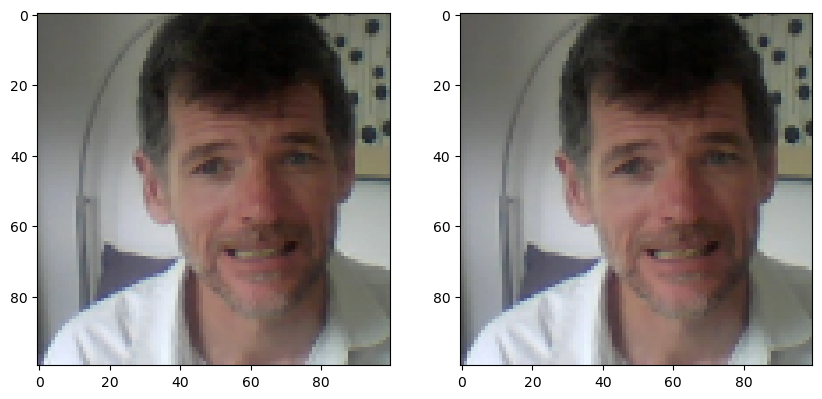

In [392]:
ELEMENT_TO_CHECK=1 #up to 12
# Set plot size 
plt.figure(figsize=(10,8))

# Set first subplot
plt.subplot(1,2,1)
plt.imshow(test_input[ELEMENT_TO_CHECK])

# Set second subplot
plt.subplot(1,2,2)
plt.imshow(test_val[ELEMENT_TO_CHECK])

# Renders cleanly
plt.show()

# 7. Save Model

In [394]:
# Save weights
name_to_save='siamesemodelv7'
siamese_model.save(name_to_save + '.h5')
siamese_model.save(name_to_save + '.keras')

In [396]:
L1Dist

__main__.L1Dist

# 7.1 Load Model

In [425]:
# Reload model 
siamese_model = tf.keras.models.load_model(name_to_save + '.h5', 
                                   custom_objects={'L1Dist':L1Dist, 'BinaryCrossentropy':tf.losses.BinaryCrossentropy})

In [399]:
# Make predictions with reloaded model
siamese_model.predict([test_input, test_val])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 163ms/step


array([[9.9999392e-01],
       [7.8914595e-01],
       [3.1971897e-10],
       [9.9999571e-01],
       [1.0000000e+00],
       [9.9865907e-01],
       [1.0000000e+00],
       [2.9516699e-05],
       [3.4001468e-10],
       [9.9991488e-01],
       [9.9951684e-01],
       [8.9614541e-06]], dtype=float32)

In [401]:
# View model summary
siamese_model.summary()

Model: "SiameseNetwork"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_img           │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ validation_img      │ (None, 100, 100,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ embedding           │ (None, 4096)      │ 38,960,448 │ input_img[0][0],  │
│ (Functional)        │                   │            │ validation_img[0… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ l1_dist_2 (L1Dist)  │ (None, 4096)      │          0 │ embedding[0][0],  │
│                     │                   │            │ embedding[1][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 1)         │      4,097 │ l1_dist_2[0][0]   │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 38,964,545 (148.64 MB)

 Trainable params: 38,964,545 (148.64 MB)

 Non-trainable params: 0 (0.00 B)

# 8. Real Time Test

## 8.1 Verification Function

In [405]:
#application_data\verification_images

In [407]:
print('There are ' + str(len(os.listdir(os.path.join('application_data', 'verification_images')))) + ' images in the verification images dir')

There are 55 images in the verification images dir


In [409]:
os.path.join('application_data', 'input_image', 'input_image.jpg')

'application_data\\input_image\\input_image.jpg'

In [413]:
#ok

def verify(model, detection_threshold, verification_threshold):
    # Build results array
    input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
    verification_images_dir = os.path.join('application_data', 'verification_images')
    results = []
    for image in os.listdir(verification_images_dir):
        validation_img = preprocess(os.path.join(verification_images_dir, image))
        
        # Make Predictions 
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        results.append(result)
    
    # Detection Threshold: Metric above which a prediciton is considered positive 
    detection = np.sum(np.array(results) > detection_threshold)
    
    # Verification Threshold: Proportion of positive predictions / total positive samples 
    verification = detection / len(os.listdir(verification_images_dir))
    verified = verification > verification_threshold
    
    return results, verified

In [439]:
def verify2(model, detection_threshold=0.6, validation_threshold=0.6, clip_threshold=0.999):
    # Preprocess the input image
    input_img = preprocess(os.path.join('application_data', 'input_image', 'input_image.jpg'))
    verification_images_dir = os.path.join('application_data', 'verification_images')
    results = []

    # Process each image in the verification directory
    for image in os.listdir(verification_images_dir):
        validation_img = preprocess(os.path.join(verification_images_dir, image))
        
        # Make Predictions
        result = model.predict(list(np.expand_dims([input_img, validation_img], axis=1)))
        
        # Clip result to avoid very high values
        clipped_result = np.clip(result, 0, clip_threshold)
        
        results.append(clipped_result)
    
    # Convert results to numpy array for easier handling
    results = np.array(results)
    
    # Calculate detection and verification
    detection = np.sum(results > detection_threshold)
    verification = detection / len(os.listdir(verification_images_dir))
    verified = verification > validation_threshold

    # Debug outputs
    print(f"Results: {results}")
    print(f"Detections (above threshold {detection_threshold}): {detection}")
    print(f"Total verification images: {len(os.listdir(verification_images_dir))}")
    print(f"Verification rate: {verification}")
    print(f"Verified: {verified}")

    return results, verified

## 8.2 OpenCV Real Time Verification

In [438]:
#ok  -> verify 0.75, 0.75, 0.999 with square detection
# Initialize the webcam
print( "info: opening webcam capture on: " + str(WEBCAM) )
print("usage: with the cursor in focus on the webcam window, press:")
print("       v) to gather INPUT images")
print("       q) to quit")
collect_validate = True
validate_input = 0
how_many_to_validate = 10
done_enough = False

cap = cv2.VideoCapture(WEBCAM)
try:
    while cap.isOpened(): 
        ret, frame = cap.read()
        
        if not ret:
            print("problem: Failed to grab frame from webcam")
            break

        # Cut down frame to 250x250px
        frame = frame[120:120+250,200:200+250, :]
        
        # Create a copy of the frame before any modifications
        original_frame = frame.copy()

        # Convert the image to RGB (optional, depending on your face detection function)
        rgb_frame = frame
 
        # Perform face detection
        detections = detect_faces(rgb_frame)
    
        # Extract detection results
        detection_boxes = detections['detection_boxes'][0].numpy()
        detection_scores = detections['detection_scores'][0].numpy()

        # Loop through detections and draw boxes around faces
        height, width, _ = frame.shape
        for i in range(detection_boxes.shape[0]):
            if detection_scores[i] >= 0.5:  # Confidence threshold
                box = detection_boxes[i]
                y1, x1, y2, x2 = int(box[0] * height), int(box[1] * width), int(box[2] * height), int(box[3] * width)

                # draw the bounding box
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 255), 2)  # Yellow box (BGR: 0, 255, 255)

                # Prepare the label with the detection score
                label = f'{detection_scores[i]:.2f}'

                # Calculate the position for the label
                label_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
                # here the label would be on top of the rectangle
                #label_x1, label_y1 = x1, y1 - label_size[1] - 10
                #label_x2, label_y2 = label_x1 + label_size[0], label_y1 + label_size[1] + 10
                # here the label is in the rectangle top left
                label_x1, label_y1 = x1, y1
                label_x2, label_y2 = x1 + label_size[0] + 10, y1 + label_size[1] + 10
                # Draw a filled rectangle for the label background
                cv2.rectangle(frame, (label_x1, label_y1), (label_x2, label_y2), (0, 255, 255), cv2.FILLED)
                
                # Put the detection score text on the label background
                # on top of the rectangle
                # cv2.putText(frame, label, (x1, y1 - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)
                # inside the rectangle
                cv2.putText(frame, label, (x1 + 5, y1 + label_size[1] + 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

                # Collect input
                if detection_scores[i] >= 0.81 and collect_validate:
                    if validate_input >= how_many_to_gather:
                        collect_validate = False
                        break
                    if validate_input < how_many_to_gather:
                        imgname = os.path.join(POS_PATH, f'{uuid.uuid4().int}.jpg')
                        validate_input += 1
                        cv2.imwrite(imgname, original_frame)  # Save the original frame
                        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
                        # Run verification
                        results, verified = verify2(siamese_model, 0.75, 0.75, 0.999)  # Use the correct model
                        print(f"Verification result: {verified}")
                        print(f"Raw results: {results}")
                        # Extracting the result value
                        if isinstance(results, list) and len(results) > 0:
                            result_value = results[0][0][0] if isinstance(results[0], list) and len(results[0]) > 0 else results[0]
                            print("Result value1:", result_value)
                        elif isinstance(results, np.ndarray):
                            result_value = results[0, 0, 0]
                            print("Result value2:", result_value)
                        else:
                            print("Unable to extract result value from results:", results)

                # Quit when 10 images have been validated
                if validate_input >= how_many_to_validate:
                    print(f'Quitting collection because {how_many_to_validate} images were tested.')
                    done_enough = True
                    break

        # Display the resulting frame
        cv2.imshow('Face Detection', frame)
    
        # Breaking gracefully
        if (cv2.waitKey(1) & 0xFF == ord('q')) or done_enough:
            break

except Exception as e:
    print( "problem: could not process the webcam.")
    print(f"An error occurred: {e}")
finally:
    # Release the webcam
    cap.release()
    # Close the image show frame
    cv2.destroyAllWindows()

info: opening webcam capture on: 1
usage: with the cursor in focus on the webcam window, press:
       v) to gather INPUT images
       q) to quit
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 51ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 49ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 46ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 48ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 47ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 45ms/step
1/1 ━━━━━━━━━━━━━

In [453]:
np.squeeze(results) > 0.5

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True, False,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True])

In [442]:

# Initialize the webcam
print( "info: opening webcam capture on: " + str(WEBCAM) )
print("usage: with the cursor in focus on the webcam window, press:")
print("       v) to gather INPUT images")
print("       q) to quit")
collect_validate = True
validate_input = 0
how_many_to_validate = 10
done_enough = False

cap = cv2.VideoCapture(WEBCAM)
# Your existing main loop code adjusted for better debugging
try:
    while cap.isOpened():
        ret, frame = cap.read()
        
        if not ret:
            print("problem: Failed to grab frame from webcam")
            break

        # Cut down frame to 250x250px
        frame = frame[120:120+250, 200:200+250, :]
        
        # Create a copy of the frame before any modifications
        original_frame = frame.copy()

        # Convert the image to RGB (optional, depending on your face detection function)
        rgb_frame = frame
 
        # Perform face detection
        detections = detect_faces(rgb_frame)
    
        # Extract detection results
        detection_boxes = detections['detection_boxes'][0]
        detection_scores = detections['detection_scores'][0]

        # Loop through detections and draw boxes around faces
        height, width, _ = frame.shape
        for i in range(detection_boxes.shape[0]):
            if detection_scores[i] >= 0.5:  # Confidence threshold
                box = detection_boxes[i]
                y1, x1, y2, x2 = int(box[0] * height), int(box[1] * width), int(box[2] * height), int(box[3] * width)

                # Draw the bounding box
                cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 255), 2)  # Yellow box (BGR: 0, 255, 255)

                # Prepare the label with the detection score
                label = f'{detection_scores[i]:.2f}'

                # Calculate the position for the label
                label_size, _ = cv2.getTextSize(label, cv2.FONT_HERSHEY_SIMPLEX, 0.5, 1)
                # Here the label is in the rectangle top left
                label_x1, label_y1 = x1, y1
                label_x2, label_y2 = x1 + label_size[0] + 10, y1 + label_size[1] + 10
                # Draw a filled rectangle for the label background
                cv2.rectangle(frame, (label_x1, label_y1), (label_x2, label_y2), (0, 255, 255), cv2.FILLED)
                
                # Put the detection score text on the label background
                cv2.putText(frame, label, (x1 + 5, y1 + label_size[1] + 5), cv2.FONT_HERSHEY_SIMPLEX, 0.5, (0, 0, 0), 1)

                # Collect positives
                if detection_scores[i] >= 0.81 and collect_validate:
                    if validate_input < how_many_to_validate:
                        imgname = os.path.join(POS_PATH, f'{uuid.uuid4().int}.jpg')
                        validate_input += 1
                        collect_validate = False
                        cv2.imwrite(imgname, original_frame)  # Save the original frame
                        cv2.imwrite(os.path.join('application_data', 'input_image', 'input_image.jpg'), frame)
                        # Run verification
                        results, verified = verify2(siamese_model,  0.75, 0.75, 0.999)  # Use the correct model
                        print(f"Verification result: {verified}")
                        print(f"Raw results: {results}")
                        # Extracting the result value
                        if isinstance(results, list) and len(results) > 0:
                            result_value = results[0][0][0] if isinstance(results[0], list) and len(results[0]) > 0 else results[0]
                            print("Result value1:", result_value)
                        elif isinstance(results, np.ndarray):
                            result_value = results[0, 0, 0]
                            print("Result value2:", result_value)
                        else:
                            print("Unable to extract result value from results:", results)

                # Quit when 10 images have been validated
                if validate_input >= how_many_to_validate:
                    print(f'Quitting collection because {how_many_to_validate} images were tested.')
                    done_enough = True
                    break

        # Display the resulting frame
        cv2.imshow('Face Detection', frame)
    
        # Breaking gracefully
        if (cv2.waitKey(1) & 0xFF == ord('q')) or done_enough:
            break

except Exception as e:
    print("problem: could not process the webcam.")
    print(f"An error occurred: {e}")
finally:
    # Release the webcam
    cap.release()
    # Close the image show frame
    cv2.destroyAllWindows()


info: opening webcam capture on: 1
usage: with the cursor in focus on the webcam window, press:
       v) to gather INPUT images
       q) to quit
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 67ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 88ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 91ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 70ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 64ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 73ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 72ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 68ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 69ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 63ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 66ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 79ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 59ms/step
1/1 ━━━━━━━━━━━━━

In [430]:
np.sum(np.squeeze(results) > 0.8)

32

In [457]:
print(str(np.sum(np.squeeze(results))))

27.548819
